##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Advanced automatic differentiation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/advanced_autodiff"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/advanced_autodiff.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/advanced_autodiff.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/advanced_autodiff.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

The [Introduction to gradients and automatic differentiation](autodiff.ipynb) guide includes everything required to calculate gradients in TensorFlow. This guide focuses on deeper, less common features of the `tf.GradientTape` API.

## Setup

Note: This tutorial only needs the `tf-nightly` package  to document the custom gradient SavedModel changes available from TensorFlow 2.6.

In [ ]:
!pip uninstall tensorflow keras -y
!pip install tf-nightly

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)

## Controlling gradient recording

In the [automatic differentiation guide](autodiff.ipynb) you saw how to control which variables and tensors are watched by the tape while building the gradient calculation.

The tape also has methods to manipulate the recording.

### Stop recording

If you wish to stop recording gradients, you can use `tf.GradientTape.stop_recording` to temporarily suspend recording.

This may be useful to reduce overhead if you do not wish to differentiate a complicated operation in the middle of your model.  This could include calculating a metric or an intermediate result:

In [ ]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  x_sq = x * x
  with t.stop_recording():
    y_sq = y * y
  z = x_sq + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

### Reset/start recording from scratch

If you wish to start over entirely, use `tf.GradientTape.reset`. Simply exiting the gradient tape block and restarting is usually easier to read, but you can use the `reset` method when exiting the tape block is difficult or impossible.

In [ ]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)
reset = True

with tf.GradientTape() as t:
  y_sq = y * y
  if reset:
    # Throw out all the tape recorded so far.
    t.reset()
  z = x * x + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

## Stop gradient flow with precision

In contrast to the global tape controls above, the `tf.stop_gradient` function is much more precise. It can be used to stop gradients from flowing along a particular path, without needing access to the tape itself:

In [ ]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  y_sq = y**2
  z = x**2 + tf.stop_gradient(y_sq)

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

## Custom gradients

In some cases, you may want to control exactly how gradients are calculated rather than using the default. These situations include:

1. There is no defined gradient for a new op you are writing.
2. The default calculations are numerically unstable.
3. You wish to cache an expensive computation from the forward pass.
4. You want to modify  a value (for example, using `tf.clip_by_value` or `tf.math.round`) without modifying the gradient.

For the first case, to write a new op you can use `tf.RegisterGradient` to set up your own (refer to the API docs for details). (Note that the gradient registry is global, so change it with caution.)

For the latter three cases, you can use `tf.custom_gradient`.

Here is an example that applies `tf.clip_by_norm` to the intermediate gradient:

In [ ]:
# Establish an identity operation, but clip during the gradient pass.
@tf.custom_gradient
def clip_gradients(y):
  def backward(dy):
    return tf.clip_by_norm(dy, 0.5)
  return y, backward

v = tf.Variable(2.0)
with tf.GradientTape() as t:
  output = clip_gradients(v * v)
print(t.gradient(output, v))  # calls "backward", which clips 4 to 2

Refer to the `tf.custom_gradient` decorator API docs for more details.

### Custom gradients in SavedModel

Note: This feature will be available from TensorFlow 2.6.

Custom gradients can be saved to SavedModel by using the option `tf.saved_model.SaveOptions(experimental_custom_gradients=True)`.

To be saved into the SavedModel, the gradient function must be traceable (to learn more, check out the [Better performance with tf.function](function.ipynb) guide).

In [ ]:
class MyModule(tf.Module):

  @tf.function(input_signature=[tf.TensorSpec(None)])
  def call_custom_grad(self, x):
    return clip_gradients(x)

model = MyModule()

In [ ]:
tf.saved_model.save(
    model,
    'saved_model',
    options=tf.saved_model.SaveOptions(experimental_custom_gradients=True))

# The loaded gradients will be the same as the above example.
v = tf.Variable(2.0)
loaded = tf.saved_model.load('saved_model')
with tf.GradientTape() as t:
  output = loaded.call_custom_grad(v * v)
print(t.gradient(output, v))

A note about the above example: If you try replacing the above code with `tf.saved_model.SaveOptions(experimental_custom_gradients=False)`, the gradient will still produce the same result on loading. The reason is that the gradient registry still contains the custom gradient used in the function `call_custom_op`. However, if you restart the runtime after saving without custom gradients, running the loaded model under the `tf.GradientTape` will throw the error: `LookupError: No gradient defined for operation 'IdentityN' (op type: IdentityN)`.

## Multiple tapes

Multiple tapes interact seamlessly.

For example, here each tape watches a different set of tensors:

In [ ]:
x0 = tf.constant(0.0)
x1 = tf.constant(0.0)

with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
  tape0.watch(x0)
  tape1.watch(x1)

  y0 = tf.math.sin(x0)
  y1 = tf.nn.sigmoid(x1)

  y = y0 + y1

  ys = tf.reduce_sum(y)

In [ ]:
tape0.gradient(ys, x0).numpy()   # cos(x) => 1.0

In [ ]:
tape1.gradient(ys, x1).numpy()   # sigmoid(x1)*(1-sigmoid(x1)) => 0.25

### Higher-order gradients

Operations inside of the `tf.GradientTape` context manager are recorded for automatic differentiation. If gradients are computed in that context, then the gradient computation is recorded as well. As a result, the exact same API works for higher-order gradients as well.

For example:

In [ ]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    y = x * x * x

  # Compute the gradient inside the outer `t2` context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t1.gradient(y, x)
d2y_dx2 = t2.gradient(dy_dx, x)

print('dy_dx:', dy_dx.numpy())  # 3 * x**2 => 3.0
print('d2y_dx2:', d2y_dx2.numpy())  # 6 * x => 6.0

While that does give you the second derivative of a _scalar_ function, this pattern does not generalize to produce a Hessian matrix, since `tf.GradientTape.gradient` only computes the gradient of a scalar. To construct a [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix), go to the [Hessian example](#hessian) under the [Jacobian section](#jacobians).

"Nested calls to `tf.GradientTape.gradient`" is a good pattern when you are calculating a scalar from a gradient, and then the resulting scalar acts as a source for a second gradient calculation, as in the following example.


#### Example: Input gradient regularization

Many models are susceptible to "adversarial examples". This collection of techniques modifies the model's input to confuse the model's output. The simplest implementation—such as the [Adversarial example using the Fast Gradient Signed Method attack](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm)—takes a single step along the gradient of the output with respect to the input; the "input gradient".

One technique to increase robustness to adversarial examples is [input gradient regularization](https://arxiv.org/abs/1905.11468) (Finlay & Oberman, 2019), which attempts to minimize the magnitude of the input gradient. If the input gradient is small, then the change in the output should be small too.

Below is a naive implementation of input gradient regularization. The implementation is:

1. Calculate the gradient of the output with respect to the input using an inner tape.
2. Calculate the magnitude of that input gradient.
3. Calculate the gradient of that magnitude with respect to the model.

In [ ]:
x = tf.random.normal([7, 5])

layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

In [ ]:
with tf.GradientTape() as t2:
  # The inner tape only takes the gradient with respect to the input,
  # not the variables.
  with tf.GradientTape(watch_accessed_variables=False) as t1:
    t1.watch(x)
    y = layer(x)
    out = tf.reduce_sum(layer(x)**2)
  # 1. Calculate the input gradient.
  g1 = t1.gradient(out, x)
  # 2. Calculate the magnitude of the input gradient.
  g1_mag = tf.norm(g1)

# 3. Calculate the gradient of the magnitude with respect to the model.
dg1_mag = t2.gradient(g1_mag, layer.trainable_variables)

In [ ]:
[var.shape for var in dg1_mag]

## Jacobians


All the previous examples took the gradients of a scalar target with respect to some source tensor(s).

The [Jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) represents the gradients of a vector valued function. Each row contains the gradient of one of the vector's elements.

The `tf.GradientTape.jacobian` method allows you to efficiently calculate a Jacobian matrix.

Note that:

* Like `gradient`: The `sources` argument can be a tensor or a container of tensors.
* Unlike `gradient`: The `target` tensor must be a single tensor.

### Scalar source

As a first example, here is the Jacobian of a vector-target with respect to a scalar-source.

In [3]:
x = tf.linspace(-10.0, 10.0, 200+1)
delta = tf.Variable(0.0)

with tf.GradientTape() as tape:
  y = tf.nn.sigmoid(x+delta)

dy_dx = tape.jacobian(y, delta)

When you take the Jacobian with respect to a scalar the result has the shape of the **target**, and gives the gradient of the each element with respect to the source:

In [4]:
print(y.shape)
print(dy_dx.shape)

(201,)
(201,)


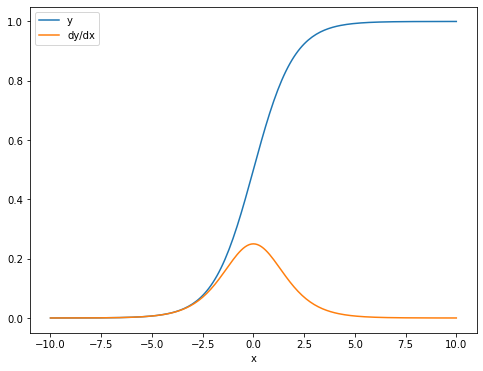

In [5]:
plt.plot(x.numpy(), y, label='y')
plt.plot(x.numpy(), dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

### Tensor source

Whether the input is scalar or tensor, `tf.GradientTape.jacobian` efficiently calculates the gradient of each element of the source with respect to each element of the target(s).

For example, the output of this layer has a shape of `(7, 10)`:

In [6]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape(persistent=True) as tape:
  y = layer(x)

y.shape

TensorShape([7, 10])

And the layer's kernel's shape is `(5, 10)`:

In [7]:
layer.kernel.shape

TensorShape([5, 10])

The shape of the Jacobian of the output with respect to the kernel is those two shapes concatenated together:

In [8]:
j = tape.jacobian(y, layer.kernel)
j.shape

TensorShape([7, 10, 5, 10])

If you sum over the target's dimensions, you're left with the gradient of the sum that would have been calculated by `tf.GradientTape.gradient`:

In [9]:
g = tape.gradient(y, layer.kernel)
print('g.shape:', g.shape)

j_sum = tf.reduce_sum(j, axis=[0, 1])
delta = tf.reduce_max(abs(g - j_sum)).numpy()
assert delta < 1e-3
print('delta:', delta)

g.shape: (5, 10)
delta: 0.0


<a id="hessian"> </hessian>

#### Example: Hessian

While `tf.GradientTape` doesn't give an explicit method for constructing a [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix) it's possible to build one using the `tf.GradientTape.jacobian` method.

Note: The Hessian matrix contains `N**2` parameters. For this and other reasons it is not practical for most models. This example is included more as a demonstration of how to use the `tf.GradientTape.jacobian` method, and is not an endorsement of direct Hessian-based optimization. A Hessian-vector product can be [calculated efficiently with nested tapes](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/eager/benchmarks/resnet50/hvp_test.py), and is a much more efficient approach to second-order optimization.

In [10]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)

In [13]:
g.shape

TensorShape([5, 8])

In [14]:
print(f'layer.kernel.shape: {layer1.kernel.shape}')
print(f'h.shape: {h.shape}')

layer.kernel.shape: (5, 8)
h.shape: (5, 8, 5, 8)


To use this Hessian for a [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) step, you would first flatten out its axes into a matrix, and flatten out the gradient into a vector:

In [16]:
n_params

<tf.Tensor: shape=(), dtype=int32, numpy=40>

In [17]:
n_params = tf.reduce_prod(layer1.kernel.shape)

g_vec = tf.reshape(g, [n_params, 1])
h_mat = tf.reshape(h, [n_params, n_params])

The Hessian matrix should be symmetric:

In [18]:
def imshow_zero_center(image, **kwargs):
  lim = tf.reduce_max(abs(image))
  plt.imshow(image, vmin=-lim, vmax=lim, cmap='seismic', **kwargs)
  plt.colorbar()

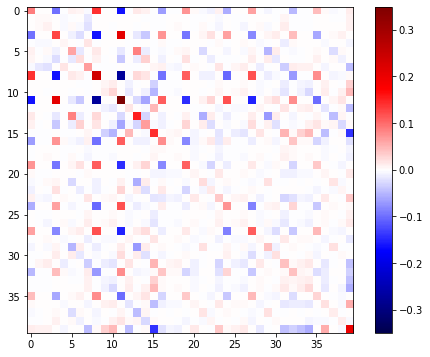

In [19]:
imshow_zero_center(h_mat)

The Newton's method update step is shown below:

In [20]:
eps = 1e-3
eye_eps = tf.eye(h_mat.shape[0])*eps

Note: [Don't  actually invert the matrix](https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/).

In [21]:
# X(k+1) = X(k) - (∇²f(X(k)))^-1 @ ∇f(X(k))
# h_mat = ∇²f(X(k))
# g_vec = ∇f(X(k))
update = tf.linalg.solve(h_mat + eye_eps, g_vec)

# Reshape the update and apply it to the variable.
_ = layer1.kernel.assign_sub(tf.reshape(update, layer1.kernel.shape))

While this is relatively simple for a single `tf.Variable`, applying this to a non-trivial model would require careful concatenation and slicing to produce a full Hessian across multiple variables.

### Batch Jacobian

In some cases, you want to take the Jacobian of each of a stack of targets with respect to a stack of sources, where the Jacobians for each target-source pair are independent.

For example, here the input `x` is shaped `(batch, ins)` and the output `y` is shaped `(batch, outs)`:


In [22]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = layer2(y)

y.shape

TensorShape([7, 6])

The full Jacobian of `y` with respect to `x` has a shape of `(batch, ins, batch, outs)`, even if you only want `(batch, ins, outs)`:

In [23]:
j = tape.jacobian(y, x)
j.shape

TensorShape([7, 6, 7, 5])

If the gradients of each item in the stack are independent, then every `(batch, batch)` slice of this tensor is a diagonal matrix:

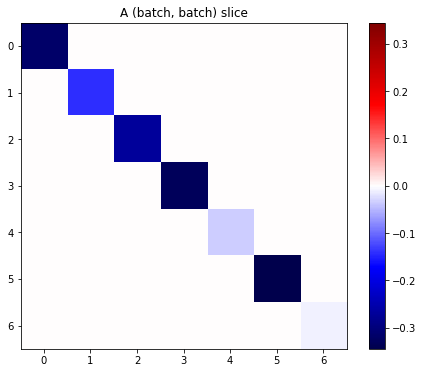

In [24]:
imshow_zero_center(j[:, 0, :, 0])
_ = plt.title('A (batch, batch) slice')

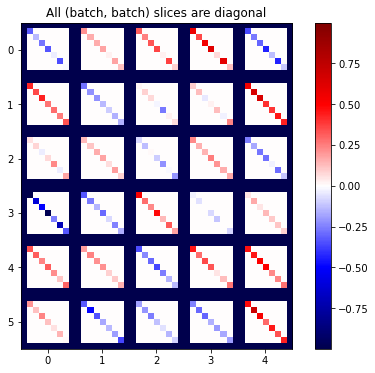

In [25]:
def plot_as_patches(j):
  # Reorder axes so the diagonals will each form a contiguous patch.
  j = tf.transpose(j, [1, 0, 3, 2])
  # Pad in between each patch.
  lim = tf.reduce_max(abs(j))
  j = tf.pad(j, [[0, 0], [1, 1], [0, 0], [1, 1]],
             constant_values=-lim)
  # Reshape to form a single image.
  s = j.shape
  j = tf.reshape(j, [s[0]*s[1], s[2]*s[3]])
  imshow_zero_center(j, extent=[-0.5, s[2]-0.5, s[0]-0.5, -0.5])

plot_as_patches(j)
_ = plt.title('All (batch, batch) slices are diagonal')

To get the desired result, you can sum over the duplicate `batch` dimension, or else select the diagonals using `tf.einsum`:

In [26]:
j_sum = tf.reduce_sum(j, axis=2)
print(j_sum.shape)
j_select = tf.einsum('bxby->bxy', j)
print(j_select.shape)

(7, 6, 5)
(7, 6, 5)


It would be much more efficient to do the calculation without the extra dimension in the first place. The `tf.GradientTape.batch_jacobian` method does exactly that:

In [27]:
jb = tape.batch_jacobian(y, x)
jb.shape

TensorShape([7, 6, 5])

In [28]:
error = tf.reduce_max(abs(jb - j_sum))
assert error < 1e-3
print(error.numpy())

0.0


Caution: `tf.GradientTape.batch_jacobian` only verifies that the first dimension of the source and target match. It doesn't check that the gradients are actually independent. It's up to you to make sure you only use `batch_jacobian` where it makes sense. For example, adding a `tf.keras.layers.BatchNormalization` destroys the independence, since it normalizes across the `batch` dimension:

In [29]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
bn = tf.keras.layers.BatchNormalization()
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = bn(y, training=True)
  y = layer2(y)

j = tape.jacobian(y, x)
print(f'j.shape: {j.shape}')

j.shape: (7, 6, 7, 5)


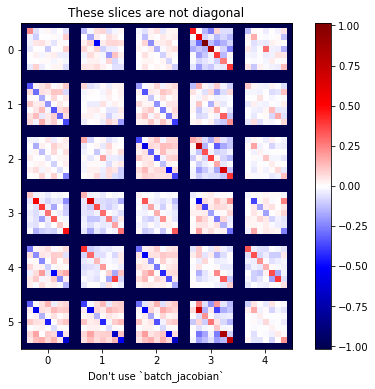

In [30]:
plot_as_patches(j)

_ = plt.title('These slices are not diagonal')
_ = plt.xlabel("Don't use `batch_jacobian`")

In this case, `batch_jacobian` still runs and returns _something_ with the expected shape, but it's contents have an unclear meaning:

In [31]:
jb = tape.batch_jacobian(y, x)
print(f'jb.shape: {jb.shape}')

jb.shape: (7, 6, 5)
